# **H1N1 Vaccine Prediction – Data Science Challenge (Group 4)**

In [ ]:
%cd Team-Project-Group4


In [ ]:
!pip install -q pandas matplotlib scikit-learn xgboost lightgbm


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving dataset_B_example_submission (1).csv to dataset_B_example_submission (1) (3).csv
Saving dataset_B_testing (1).csv to dataset_B_testing (1) (2).csv
Saving dataset_B_training.csv to dataset_B_training (3).csv


# **Import Libraries**


In [ ]:
#Importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid", palette="pastel")


# **Load and Inspect Data**

In [ ]:
#  LOAD DATA

train_df = pd.read_csv("dataset_B_training.csv")
test_df = pd.read_csv("dataset_B_testing.csv")
example_sub = pd.read_csv("dataset_B_example_submission (1) (2).csv")

print(" Training data:", train_df.shape)
print(" Test data:", test_df.shape)
train_df.head()

 Training data: (4756, 31)
 Test data: (4749, 30)


,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,sex,income_poverty,marital_status,rent_or_own,employment_status,census_msa,household_adults,household_children,employment_sector,h1n1_vaccine
0,1,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,Female,"<= $75,000, Above Poverty",Married,Own,Employed,"MSA, Not Principle City",2.0,1.0,construction,0
1,2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Female,Below Poverty,Not Married,Own,Employed,Non-MSA,0.0,3.0,wholesale,0
2,3,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,Female,"> $75,000",Not Married,Own,Employed,"MSA, Principle City",0.0,0.0,real_estate,1
3,4,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,Female,"<= $75,000, Above Poverty",Not Married,Rent,Not in Labor Force,Non-MSA,0.0,0.0,NaN,0
4,5,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Female,NaN,Not Married,NaN,Unemployed,Non-MSA,3.0,0.0,NaN,0


# **Exploratory Data Analysis (EDA)**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4756 entries, 0 to 4755
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                4756 non-null   int64  
 1   h1n1_concern                 4741 non-null   float64
 2   h1n1_knowledge               4734 non-null   float64
 3   behavioral_antiviral_meds    4739 non-null   float64
 4   behavioral_avoidance         4729 non-null   float64
 5   behavioral_face_mask         4752 non-null   float64
 6   behavioral_wash_hands        4748 non-null   float64
 7   behavioral_large_gatherings  4747 non-null   float64
 8   behavioral_outside_home      4741 non-null   float64
 9   behavioral_touch_face        4736 non-null   float64
 10  doctor_recc_h1n1             4437 non-null   float64
 11  chronic_med_condition        4595 non-null   float64
 12  child_under_6_months         4622 non-null   float64
 13  health_worker     

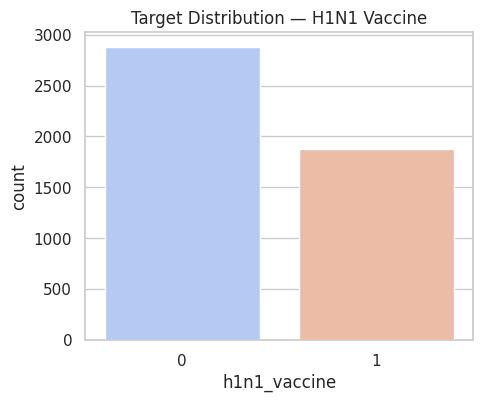

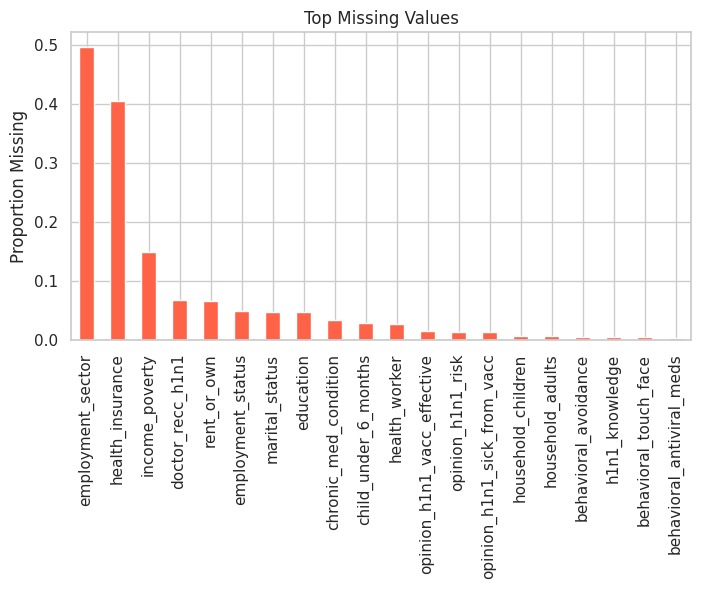

Categorical features: 10
Numerical features: 20


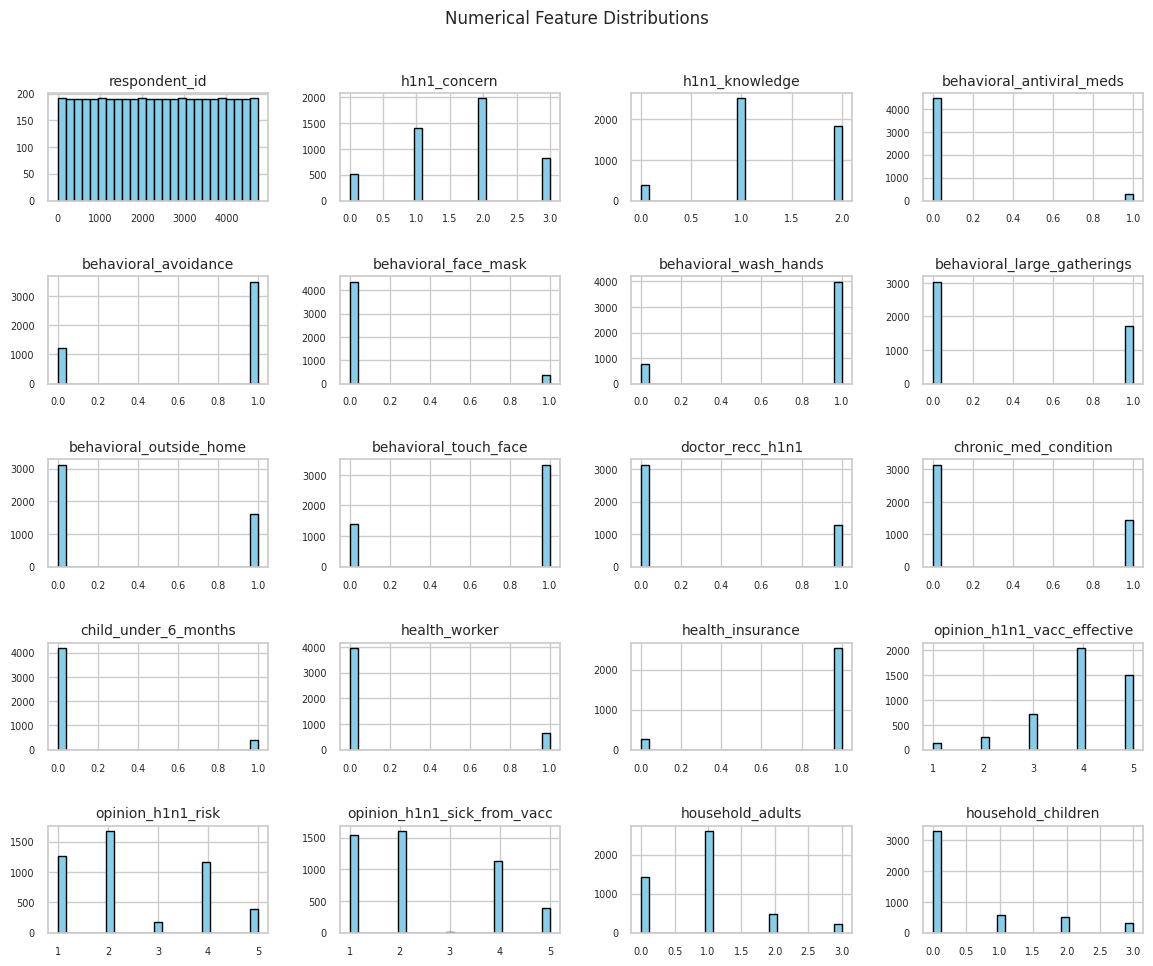

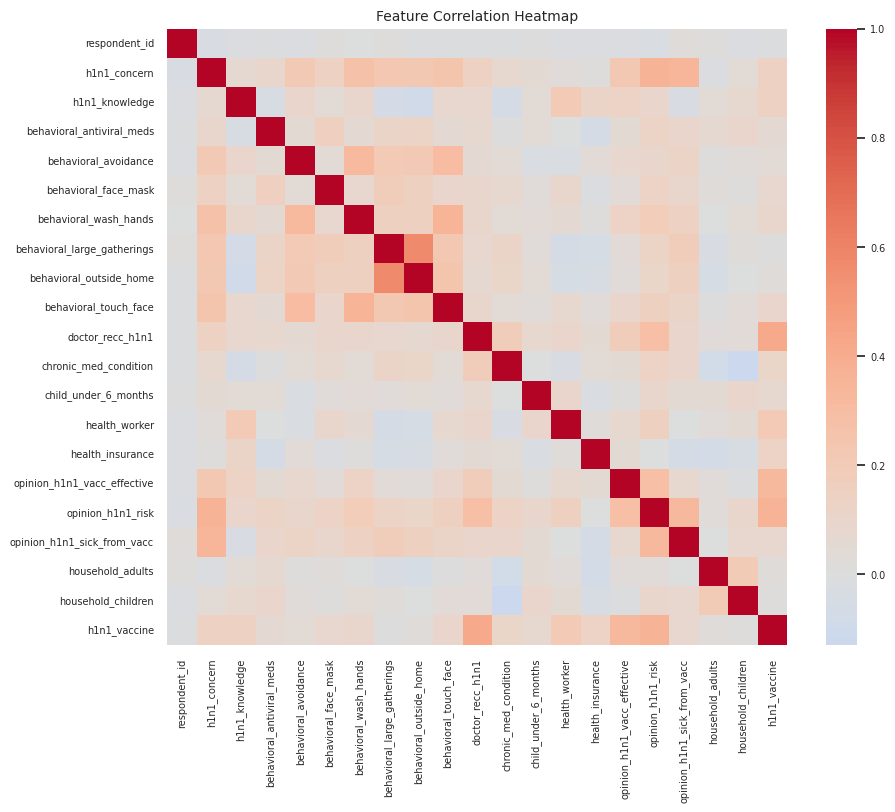

In [ ]:
#  Basic info
train_df.info()
train_df.describe(include="all").T.head(15)

#  Target distribution
plt.figure(figsize=(5,4))
sns.countplot(x="h1n1_vaccine", data=train_df, palette="coolwarm")
plt.title("Target Distribution — H1N1 Vaccine")
plt.show()

#  Missing Values
missing = train_df.isnull().mean().sort_values(ascending=False)
plt.figure(figsize=(8,4))
missing.head(20).plot(kind="bar", color="tomato")
plt.title("Top Missing Values")
plt.ylabel("Proportion Missing")
plt.show()

#  Identify numeric & categorical columns
cat_cols = train_df.select_dtypes(include="object").columns.tolist()
num_cols = train_df.select_dtypes(include=["int64","float64"]).columns.drop("h1n1_vaccine").tolist()
print(f"Categorical features: {len(cat_cols)}")
print(f"Numerical features: {len(num_cols)}")

# Numerical distributions
plt.rcParams.update({
    'axes.titlesize': 10,
    'axes.labelsize': 8,
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'legend.fontsize': 8
})

train_df[num_cols].hist(bins=25, figsize=(12,10), color="skyblue", edgecolor="black")
plt.suptitle("Numerical Feature Distributions", fontsize=12)
plt.tight_layout(pad=2)
plt.show()

#  Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(train_df[num_cols + ["h1n1_vaccine"]].corr(), cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()


# **Data Preprocessing**

In [ ]:
TARGET_COL = "h1n1_vaccine"
ID_COL = "respondent_id"

X = train_df.drop(columns=[TARGET_COL, ID_COL])
y = train_df[TARGET_COL]

# Identify numeric & categorical columns after dropping target and ID
cat_cols = X.select_dtypes(include="object").columns.tolist()
num_cols = X.select_dtypes(include=["int64","float64"]).columns.tolist()

num_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

base_preprocessor = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print(" Train:", X_train.shape, " | Valid:", X_valid.shape)

 Train: (3804, 29)  | Valid: (952, 29)


# **Model Building**

Logistic Regression: Acc 0.743 | F1 0.688 | AUC 0.816
Random Forest: Acc 0.754 | F1 0.668 | AUC 0.797
Gradient Boosting: Acc 0.762 | F1 0.681 | AUC 0.811
XGBoost: Acc 0.747 | F1 0.665 | AUC 0.798
[LightGBM] [Info] Number of positive: 1499, number of negative: 2305
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 165
[LightGBM] [Info] Number of data points in the train set: 3804, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.394059 -> initscore=-0.430282
[LightGBM] [Info] Start training from score -0.430282
LightGBM: Acc 0.732 | F1 0.645 | AUC 0.796


,Model,Accuracy,F1,AUC
0,Logistic Regression,0.742647,0.687898,0.816125
2,Gradient Boosting,0.761555,0.680731,0.810736
3,XGBoost,0.746849,0.664812,0.798165
1,Random Forest,0.754202,0.667614,0.797075
4,LightGBM,0.732143,0.645341,0.795725


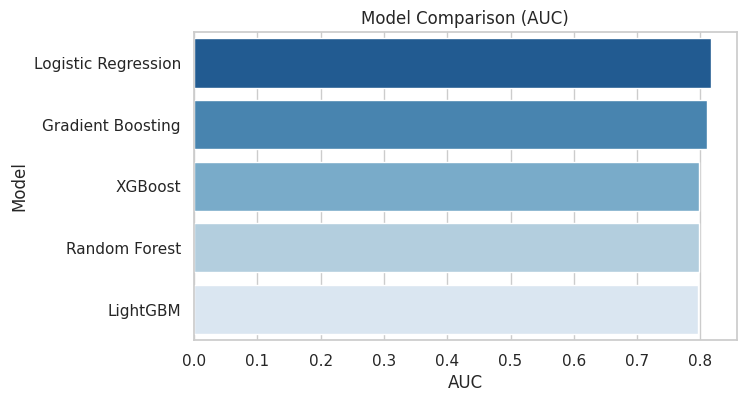

In [ ]:
# Model Building

def evaluate_model(model, X_train, y_train, X_valid, y_valid, name="Model"):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    y_prob = model.predict_proba(X_valid)[:,1] if hasattr(model, "predict_proba") else None
    acc = accuracy_score(y_valid, y_pred)
    f1  = f1_score(y_valid, y_pred)
    auc = roc_auc_score(y_valid, y_prob) if y_prob is not None else np.nan
    print(f"{name}: Acc {acc:.3f} | F1 {f1:.3f} | AUC {auc:.3f}")
    return {"Model": name, "Accuracy": acc, "F1": f1, "AUC": auc}

models = {
    "Logistic Regression": Pipeline([("prep", base_preprocessor),
        ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))]),
    "Random Forest": Pipeline([("prep", base_preprocessor),
        ("clf", RandomForestClassifier(n_estimators=400, random_state=42, class_weight="balanced"))]),
    "Gradient Boosting": Pipeline([("prep", base_preprocessor),
        ("clf", GradientBoostingClassifier(random_state=42))]),
    "XGBoost": Pipeline([("prep", base_preprocessor),
        ("clf", XGBClassifier(random_state=42, n_estimators=500, learning_rate=0.05,
                               max_depth=5, subsample=0.9, colsample_bytree=0.9,
                               eval_metric="logloss"))]),
    "LightGBM": Pipeline([("prep", base_preprocessor),
        ("clf", LGBMClassifier(random_state=42, n_estimators=500,
                               learning_rate=0.05, subsample=0.9, colsample_bytree=0.9))])
}

results = []
for name, model in models.items():
    results.append(evaluate_model(model, X_train, y_train, X_valid, y_valid, name))

results_df = pd.DataFrame(results).sort_values("AUC", ascending=False)
display(results_df)

plt.figure(figsize=(7,4))
sns.barplot(x="AUC", y="Model", data=results_df, palette="Blues_r")
plt.title("Model Comparison (AUC)")
plt.show()

# **Performance Evaluation and Tuning**

 Best: Logistic Regression | AUC=0.816


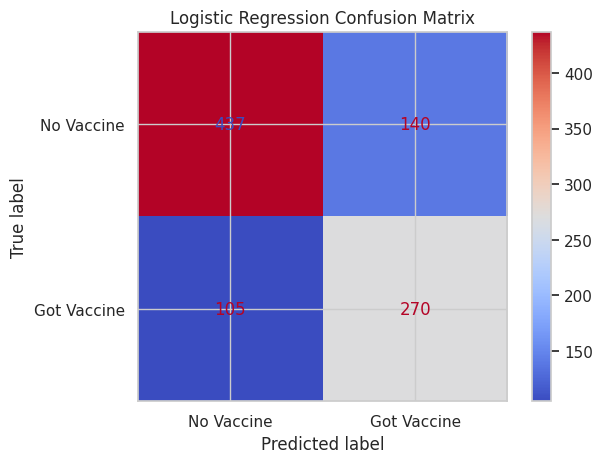

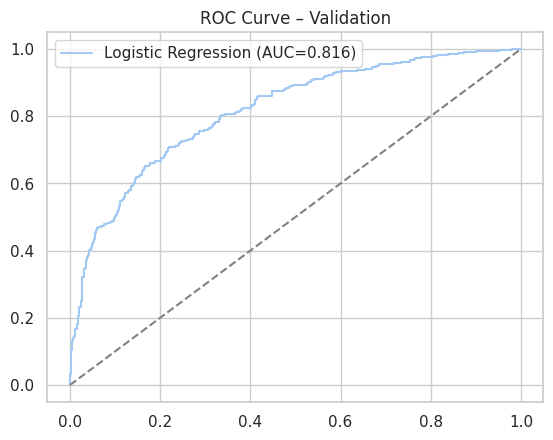

5-fold AUC: 0.8222 ± 0.0121
Best RF params: {'clf__n_estimators': 600, 'clf__min_samples_split': 2, 'clf__max_depth': 10} | AUC: 0.8261512899032605


In [ ]:
#Performance Evaluation and hyperparameter tuning

best_model_name = results_df.iloc[0]["Model"]
best_model = models[best_model_name]
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_valid)
y_prob = best_model.predict_proba(X_valid)[:,1]
print(f" Best: {best_model_name} | AUC={roc_auc_score(y_valid,y_prob):.3f}")

# Confusion Matrix
cm = confusion_matrix(y_valid, y_pred)
ConfusionMatrixDisplay(cm, display_labels=["No Vaccine","Got Vaccine"]).plot(cmap="coolwarm")
plt.title(f"{best_model_name} Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_valid, y_prob)
plt.plot(fpr, tpr, label=f"{best_model_name} (AUC={roc_auc_score(y_valid,y_prob):.3f})")
plt.plot([0,1],[0,1],'--',color='grey')
plt.legend(); plt.title("ROC Curve – Validation"); plt.show()

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_auc = cross_val_score(best_model, X, y, scoring="roc_auc", cv=cv)
print(f"5-fold AUC: {cv_auc.mean():.4f} ± {cv_auc.std():.4f}")

# hyper-parameter tuning
rf = Pipeline([("prep", base_preprocessor),
    ("clf", RandomForestClassifier(random_state=42,class_weight="balanced"))])
param = {"clf__n_estimators":[200,400,600],"clf__max_depth":[5,10,None],"clf__min_samples_split":[2,5,10]}
search = RandomizedSearchCV(rf,param_distributions=param,n_iter=6,scoring="roc_auc",cv=3,n_jobs=-1,random_state=42)
search.fit(X_train,y_train)
print("Best RF params:",search.best_params_,"| AUC:",search.best_score_)


# **Final Submission**

 Saved: submission_1_logistic_regression.csv
 Saved: submission_2_gradient_boosting.csv
 Saved: submission_3_xgboost.csv
 Saved: submission_4_random_forest.csv
[LightGBM] [Info] Number of positive: 1874, number of negative: 2882
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001835 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 165
[LightGBM] [Info] Number of data points in the train set: 4756, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.394029 -> initscore=-0.430409
[LightGBM] [Info] Start training from score -0.430409
 Saved: submission_5_lightgbm.csv


,Model,Accuracy,F1,AUC,Submission_File
0,Logistic Regression,0.742647,0.687898,0.816125,submission_1_logistic_regression.csv
1,Gradient Boosting,0.761555,0.680731,0.810736,submission_2_gradient_boosting.csv
2,XGBoost,0.746849,0.664812,0.798165,submission_3_xgboost.csv
3,Random Forest,0.754202,0.667614,0.797075,submission_4_random_forest.csv
4,LightGBM,0.732143,0.645341,0.795725,submission_5_lightgbm.csv


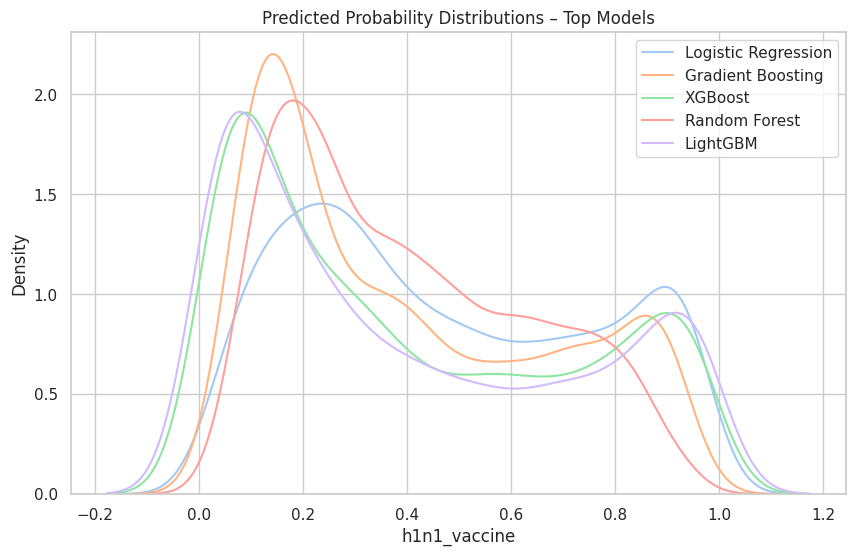


 All 5 submission files and summary CSV ready for Canvas upload.


In [ ]:
#Final Submission of files
ID_COL = "respondent_id"
X_test = test_df.drop(columns=[ID_COL])
test_ids = test_df[ID_COL]

top5 = results_df["Model"].head(5).tolist()
submissions = {}

for i, name in enumerate(top5, start=1):
    model = models[name]
    model.fit(X, y)
    preds = model.predict_proba(X_test)[:,1]
    sub = pd.DataFrame({ID_COL: test_ids, "h1n1_vaccine": preds})
    fname = f"submission_{i}_{name.replace(' ','_').lower()}.csv"
    sub.to_csv(fname, index=False)
    submissions[name] = sub
    print(f" Saved: {fname}")

summary = results_df.set_index("Model").loc[top5].reset_index()
summary["Submission_File"] = [f"submission_{i}_{n.replace(' ','_').lower()}.csv" for i,n in enumerate(top5, 1)]
summary.to_csv("submission_summary.csv", index=False)
display(summary)

plt.figure(figsize=(10,6))
for n in top5:
    sns.kdeplot(submissions[n]["h1n1_vaccine"], label=n)
plt.title("Predicted Probability Distributions – Top Models")
plt.legend(); plt.show()

print("\n All 5 submission files and summary CSV ready for Canvas upload.")
